To allow the next code blocks to run smoothly, this section sets a couple of settings.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

Set the random seed to a fixed number. This will guarantee that the notebook output is generated the same way for every run, otherwise the seed would be – random, as the name suggests.

In [2]:
np.random.seed(42)

Some figure plotting settings: increase the axis labels of our figures a bit.

In [3]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Linear Regression

In this exercise we will implement a linear regression algorithm using the normal equation and gradient descent. We will look at the diabetes dataset, which you can load from sklearn using the commands

In [4]:
from sklearn import datasets
from sklearn.metrics import mean_squared_error

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True)

For this exercise we will just use the third feature, which is the body mass index of the diabetes patients. Using this, we want to predict a quantitative measure of disease progression, which is stored in $ \boldsymbol{y}$. To start, split the dataset by retaining the last 100 datapoints as a test set. 

In [5]:
# Select the second feature corresponding to the bmi of the diabetes patients
X=X[:,2].reshape((len(y),1))
y = y.reshape((len(y),1))

In [6]:
# Split the data into training/testing sets
X = X[:-100]
X_test = X[-100:]

# Split the targets into training/testing sets
y = y[:-100]
y_test = y[-100:]
m = len(y)

And let's plot it to get an idea what we're looking at. Of course, we do things the proper way, and put labels on our axes!

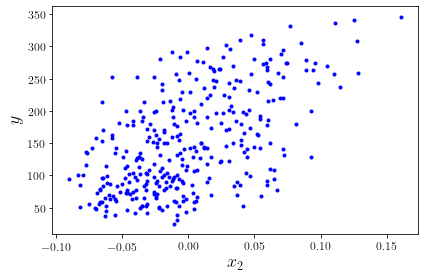

In [7]:
plt.plot(X, y, "b.")
plt.xlabel("$x_2$", fontsize=18)
plt.ylabel("$y$", fontsize=18)
plt.tight_layout()
plt.show()

We can also print a few of the generated data values, just to get an idea what we're talking about. The following command will show us the first three entries of the object `X` that we just generated:

In [8]:
X[0:3]

array([[ 0.06169621],
       [-0.05147406],
       [ 0.04445121]])

And this will show us the first three corresponding entries in the object `y`:

In [9]:
y[0:3]

array([[151.],
       [ 75.],
       [141.]])

## Linear Regression - Optimizers

### Linear regression with the normal equation

Let's start with something simple: linear regression. As we've learnt before, we can use the _normal equation_ to calculate a prediction. In statistics, we usually label this as $\hat{\beta}$, because it is an estimator for the parameter vector $\beta$ of the model. The hat indicates that it's an estimator.


Reminder: what is the normal equation? And what are `X` and `y`?

$$ \hat{\beta} = \left( \mathbf{X}^T \cdot \mathbf{X} \right)^{-1} \cdot \mathbf{X}^T \cdot \mathbf{y} $$

Quick refresher:
* $\hat{\beta}$ is our estimator for the vector of parameters $\beta$. This is what we want to calculate!
* $\mathbf{x}^{(i)}$, beware that it's lower-case, is a vector which contains all features of the training instance with index i. In the data generated above, we only have one 'feature' (i.e. the bmi), which is called $x_2$. So, $\mathbf{x}^{(0)}$, the feature vector of instance number zero, includes one single value: the value of $x_2$ for that instance, as printed out with the commands above.
* $\mathbf{X}$, now it's upper-case, is a vector of _all feature vectors_ $\mathbf{x}^{(i)}$. To make things more confusing, the entries of $\mathbf{X}$ are actually not $\mathbf{x}^{(i)}$, but the transposed vectors $(\mathbf{x}^{(i)})^T$. People sometimes call them _row vectors_ because it's like having a row in matrix, instead of a column.
* $\mathbf{y}$ are the _true_ target values of the instances. So, this is also a vector with the same dimension as $\mathbf{X}$, but even in more complicated data structures, every entry will just be the one target value.

Now, what can we do with the normal equation? And what _is_ actually this $\beta$? It's our vector of model parameters. The above case is very simple: we would like to create a model that represents the data as well as possible. With just looking at the plot, and without too much thinking, it's obvious that there is some sort of linear dependence between $x_1$ and $y$.

How many parameters do we need to describe this model? Probably two: one for the linear dependence, and one _bias term_ to shift the entire model along the y axis. So, our $\beta$ in this case is just a vector of two entries, and the goal of 'linear regression' is to find the optimal values of the two.

Without using any machine learning yet, we can just use the above normal equation to get estimators for the two values. For that, we can make use of numpy's `linalg.inv()` function to invert matrices. Essentially, we then just need to 'type' the above formula into python and let our computer do the rest. Easy, right?

One more step is necessary: we need to append an additional feature $x_0 = 1$ to all instances, because otherwise we would ignore the bias parameter in our calculation:

In [10]:
X_b = np.c_[np.ones((m, 1)), X]

Cool. Now, here's the typed-out formula for calculating the normal equation. It only uses numpy functions, such as the matrix inversion, or the calculation of dot products:

In [11]:
beta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

How do we know it worked? One easy thing is to check what the values of the two parameters are:

In [12]:
print("beta_0 = %s" % beta[0][0])
print("beta_1 = %s" % beta[1][0])

beta_0 = 152.27671846254788
beta_1 = 953.360627200114


Maybe it is also useful to plot the prediction as a line into the plot. For that, we should first calculate the predictions for the value of `y` for all our instances:

In [13]:
y_predict = X_b.dot(beta)

And now we can do the plotting:

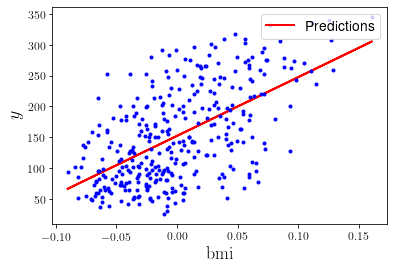

In [14]:
plt.plot(X, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$\mathrm{bmi}$", fontsize=18)
plt.ylabel("$y$", fontsize=18)
plt.legend(loc="upper right", fontsize=14)
plt.show()

Great! As a quick summary: we imported the diabetes data in python, determined an appropriate model to represent that data (by eye-balling very carefully), and used the normal equation to get estimators for our model parameters. Now, let's start with some actual machine learning.

### Linear regression using batch gradient descent

Let's try and implement the first machine-learning algorithm to solve our linear-regression problem: batch gradient descent. Quick reminder: gradient descent is an iterative approach to find $\hat{\beta}$. Using the learning rate $\eta$, we adjust our estimates for $\beta$ in each learning step iteratively. The "direction" of adjustment is determined by the _gradient_ of the mean square error.

Maybe we should have a quick revision of the formula:

$$ \mathit{MSE}(\beta) = \frac{1}{m} \sum_{i=1}^{m} \left( \beta^T \cdot \mathbf{x}^{(i)} - y^{(i)} \right)^2 $$

Now, most of you will probably know that the gradient of this function just means taking the derivative of it with respect to $\beta_1,\dots,\beta_n$. To refresh your memory, let's write down the formula for the partial derivative as well:

$$ \frac{\partial}{\partial \beta_j} \mathit{MSE}(\beta) = \frac{2}{m} \sum_{i=1}^{m} \left( \beta^T \cdot \mathbf{x}^{(i)} - y^{(i)} \right) x_j^{(i)}$$ 

Then, the entire gradient is:

$$ \nabla_\beta \mathit{MSE}(\beta) = \frac{2}{m} \mathbf{X}^T \cdot \left( \mathbf{X} \cdot \beta - \mathbf{y} \right) $$

Now it's really just one last step missing: we need to calculate our predictions for $\beta$. For the very first step, we start with random values of $\beta$. Then, after calculating the gradient above for a step, we update the value of $\beta$ according to:

$$ \beta \rightarrow \beta - \eta \nabla_\beta \mathit{MSE}(\beta) $$

That wasn't too hard, was it? Writing this out with python is even easier. Let's start with setting a learning rate $\eta$:

In [15]:
eta = 0.25

Then, we also need to decide how many steps of calculations we would like to perform:

In [16]:
n_iterations = 10000

And initialise our $\beta$ with random values: 

In [17]:
beta = np.random.randn(2,1)   # let's start with random values

Then, it's really just creating a small loop and implementing the calculation of the gradients, and then updating $\beta$:

In [18]:
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(beta) - y)
    beta = beta - eta * gradients

Cool, but did it do anything? We should probably check the values for $\beta$ once again:

In [19]:
print("beta_0 = %s" % beta[0][0])
print("beta_1 = %s" % beta[1][0])

beta_0 = 152.27671303607463
beta_1 = 953.3411487870576


You might be surprised to see that these values basically are _exactly_ the same as those obtained with the normal equation. That's because our estimate, as much as before, completely depends on the data points we fed into the model. You can go to the earlier cells, change some of the parameters, and run the code again. Does anything change, for example when adjusting to use a larger/smaller dataset (the `m` parameter)?

Now, the implementation of batch gradient descent looks rather simple, but it's really not that obvious what happens in each step of the iteration. Remember: we look at the data points ten thousand times, calculate some gradient ten thousand times, update our estimate for $\beta$ ten thousand times, and only see the final result of that final step.

Now we repeat the batch gradient descent method on the same dataset as before, but with different learning rates. When you execute the code, you'll see that the model with a very low learning rate only very slowly 'approaches' the dataset. The second one seems to be somewhat faster in comparison. The third one, however, converges really fast.

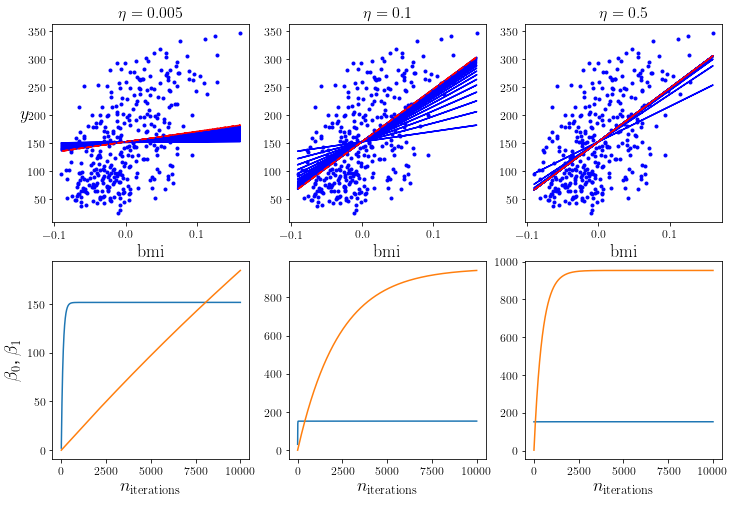

In [20]:
def plot_gradient_descent(beta, eta):
    plt.plot(X, y, "b.")
    n_iterations = 10000
    betas = []
    
    for iteration in range(n_iterations):
        if iteration%500 == 0 and iteration >0:
            y_predict = X_b.dot(beta)
            style = "b-" 
            plt.plot(X, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(beta) - y)
        beta = beta - eta * gradients
        betas.append(beta)
        
    y_predict = X_b.dot(beta)
    style = "r--"
    plt.plot(X, y_predict, style)
    plt.xlabel("$\mathrm{bmi}$", fontsize=18)
    
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    return betas

np.random.seed(42)
beta = np.random.randn(2,1)

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.ylabel("$y$", rotation=0, fontsize=18)
predictions_005 = plot_gradient_descent(beta, eta=0.005)
plt.subplot(232)
predictions_100 = plot_gradient_descent(beta, eta=0.1)
plt.subplot(233)
predictions_500 = plot_gradient_descent(beta, eta=0.5)
plt.subplot(234)

plt.xlabel("$n_{\mathrm{iterations}}$", fontsize=18)
plt.ylabel("$\\beta_0$, $\\beta_1$", fontsize=18)
plt.plot([i[0] for i in predictions_005])
plt.plot([i[1] for i in predictions_005])
plt.subplot(235)

plt.xlabel("$n_{\mathrm{iterations}}$", fontsize=18)
plt.plot([i[0] for i in predictions_100])
plt.plot([i[1] for i in predictions_100])
plt.subplot(236)

plt.xlabel("$n_{\mathrm{iterations}}$", fontsize=18)
plt.plot([i[0] for i in predictions_500])
plt.plot([i[1] for i in predictions_500])
plt.show()

Try out different learning rates and see what happens. You'll notice that – at very large rates – the model won't converge.

### Stochastic Gradient Descent

At this point, you'll probably know about the most problematic aspect of BGD already: we always evaluate the _entire_ dataset at every step of the training process. That's perfect for smaller datasets, because the model will usually find the 'best' estimate for $\beta$ possible (similar to what the normal equation does). However, this is not very feasible for huge datasets.

An alternative in that case is the _stochastic gradient descent_ (SGD) method. As opposed to batch gradient descent, the stochastic technique picks one instance from the dataset _randomly_ and adjusts the estimate for $\beta$ according to that instance. This means _a lot_ of jumping around, because we follow the randomness of individual instances. On the other hand, it's computationally very inexpensive. And if it's done right, it can still find the 'best' estimate possible. However, it will _never_ converge to that 'best' estimate per se. One common technique to overcome this problem is to adjust the learning rate according to a _schedule_ during the training process. That is, start with a high learning rate and decrease it constantly to help the model to 'settle' in the global minimum.

Back to hands-on experience. Let's first decide for how many _epochs_ we would like to evaluate. The idea for this is that, despite an instance being picked randomly at every step, we would still want to evaluate them in sets of a certain size (which is usually just the size of the training data). Once we did, we call that an epoch and jump to the next one.

In [21]:
n_epochs = 500

Then, we should implement this learning-rate scheduling, because otherwise our model would not converge. Let's write a simple function to return a learning rate with two parameters:

In [22]:
t0, t1 = 150, 500  
def learning_schedule(t):
    return t0 / (t + t1)

Once again, we'll have to initialise our $\beta$ randomly before the first calculation:

In [23]:
beta = np.random.randn(2,1)

Then we can do the actual implementation of the loops:

In [24]:
# Create a loop over the number of epochs.
for epoch in range(n_epochs):
    # And a loop over the size of the training data.
    for i in range(m):
        # Pick a random instance: this function takes
        # a random value in the range from 0 to m.
        random_index = np.random.randint(m)
        
        # Now, store this random instance and its target
        # value into the variables xi and yi ...
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]

        # ... and calculate gradients and beta as before.
        # Remember to calculate the value of the learning
        # rate from the learning-rate schedule defined
        # above (epoch * m + i) is just the number of the
        # current training step over all epochs.
        gradients = 2 * xi.T.dot(xi.dot(beta) - yi)
        eta = learning_schedule(epoch * m + i)
        beta = beta - eta * gradients

We should probably check the values for $\beta$ once again:

In [25]:
print("beta_0 = %s" % beta[0][0])
print("beta_1 = %s" % beta[1][0])

beta_0 = 149.44095341693756
beta_1 = 936.980275473478


Great, it worked! The result seems to be similar, but not the same as before. Try changing some of the parameters. For instance, increase the number of epochs. Will we eventually reach the values from before? Remember: once we reach ten thousand (!) epochs, we will have seen the same number of instances as if we had done ten thousand iteration steps in the BGD method. Another thing you could try: change the learning-rate schedule (for example: turn it off). 

To visualise the randomness of SGD, let's create some plot again. Again, you may just ignore the details of the following code:

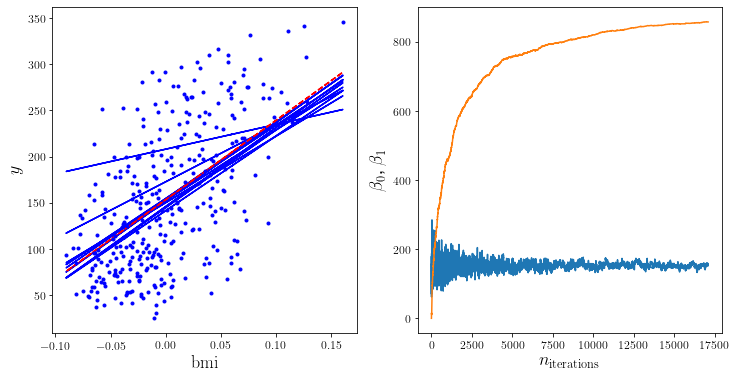

In [26]:
beta = np.random.randn(2,1)
n_epochs = 50

t0, t1 = 150, 500  
def learning_schedule(t):
    return t0 / (t + t1)

betas = []

plt.figure(figsize=(12,6))
plt.subplot(121)

for epoch in range(n_epochs):
    for i in range(m): 
        random_index = np.random.randint(m)     
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(beta) - yi)
        eta = learning_schedule(epoch * m + i)
        beta = beta - eta * gradients
        betas.append(beta)

    
    if epoch%5 == 0:
        y_predict = X_b.dot(beta)
        style = "b-" 
        plt.plot(X, y_predict, style)
            

y_predict = X_b.dot(beta)
style = "r--"
plt.plot(X, y_predict, style)
plt.plot(X, y, "b.")
plt.xlabel("$\mathrm{bmi}$", fontsize=18)
plt.ylabel("$y$", fontsize=18)

plt.subplot(122)
plt.plot([i[0] for i in betas])
plt.plot([i[1] for i in betas])

plt.xlabel("$n_{\mathrm{iterations}}$", fontsize=18)
plt.ylabel("$\\beta_0$, $\\beta_1$", fontsize=18)
plt.show()

### Side note: Mini-batch gradient descent

By 'taking the best of both worlds', the _mini-batch gradient descent_ might be the perfect compromise between BGD and SGD. Instead of taking all or just one instance, the gradient is evaluated on a _mini-batch_ of instances. This makes it a little more stable than SGD, especially with large mini-batches. And it allows for vectorisation optimisations in terms of computing. It has the same 'issue' as SGD, however, that it never stops at the optimal values for the estimators, but keeps jumping around the global minimum. Therefore, a good learning schedule is pivotal to implement this technique successfully.

## Linear Regression - Regularization

So far we only studied the performance of our models on the training dataset. However, usually we do not have a dataset which completely specifies the problem at hand, and we have to account for that by regularizing our model. This is known as the bias-variance tradeoff. 

In order to ensure that our model performs well also on the test dataset, we have to employ some kind of regularization. Before we move on to that, lets quickly check the performance of the simple linear regression, this time with the full set of features. 

In [27]:
# Load the diabetes dataset again
X, y = datasets.load_diabetes(return_X_y=True)

# Split it in train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Transform the data to include the constant term
X_train = np.c_[np.ones((len(X_train), 1)), X_train]
X_test = np.c_[np.ones((len(X_test), 1)), X_test]

In [28]:
# Calculate the estimator
beta = np.linalg.inv(np.transpose(X_train).dot(X_train)).dot(X_train.T).dot(y_train)

In [29]:
# Check for the first one
print("beta_0 = %s" % beta[0])

beta_0 = 151.00818273080336


In [30]:
# Lets see the performance on the test dataset
y_predict = X_test.dot(beta)
mse_linreg = mean_squared_error(y_predict, y_test)
print("MSE = %s" % mse_linreg)

MSE = 2821.7385595843793


Alright, now lets try to improve that!

### Ridge Regression

In class you got to know ridge regression, which uses a modified loss function 
\begin{equation}\label{eqn: Ridge}
   % L_{\textrm{ridge}}(\beta) = \sum_{i=1}^{m} \left(y_{i} -  \beta_0 +\sum_{j=1}^{n} \beta_{j}x_{ij}\right)^{2} + \lambda \sum_{j=0}^{n} \beta_{j}^{2},
    L_{\textrm{ridge}}(\beta) = \sum_{i=1}^{m} \left[y_{i} -   f(\boldsymbol{x}_i|\beta)\right]^{2} + \lambda \sum_{j=0}^{n} \beta_{j}^{2},
\end{equation}
where $\lambda > 0$ is a positive parameter. This means changing our estimator for $\beta$ to
\begin{equation} \label{eqn: Ridge Solution}
    \hat{\beta}_{\textrm{ridge}} = (\widetilde{X}^{T}\widetilde{X} + \lambda I)^{-1}\widetilde{X}^{T}y,
\end{equation}

and computing the mean squared error on the testset for various choices of $\lambda$.

In [31]:
betas_r = []
mses = []
lbdas = np.linspace(0,0.5,20)

for lbda in lbdas:
    # Compute estimators
    beta = np.linalg.inv(X_train.T.dot(X_train)+lbda*np.eye(np.shape(X_train)[1])).dot(X_train.T).dot(y_train)
    betas_r.append(beta)
    # Compute their MSE
    mses.append(mean_squared_error(X_test.dot(beta), y_test))
    

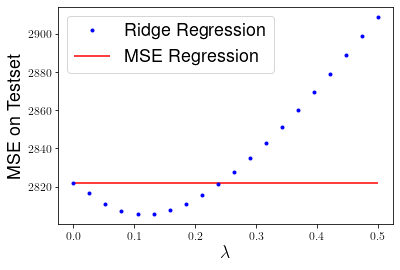

In [32]:
plt.plot(lbdas,mses,'b.', label="Ridge Regression")
plt.hlines(mse_linreg, 0, 0.5, "r", label="MSE Regression")
plt.xlabel("$\lambda$", fontsize=18)
plt.ylabel("MSE on Testset", fontsize=18)
plt.legend(fontsize=18)
plt.show()

### Lasso Regression

Another popular approach is to use the magnitude of the components $\beta_j$ in the loss function, not the square. This is know as Lasso regression, 
\begin{equation}\label{eqn: Lasso}
    L_{\textrm{lasso}}(\beta) = \sum_{i=1}^{m} \left[y_{i} -  f(\boldsymbol{x}_i|\beta)\right]^{2} + \alpha \sum_{j=0}^{n} |\beta_{j}|.
\end{equation}
Since computing the gradient is not so straightforward here, one has to consider numerical approaches like the gradient descent introduced above. Here we will use the sklearn function of lasso regression.


In [33]:
from sklearn.linear_model import Lasso

In [34]:
betas_l = []
mses = []
alphas = np.linspace(0.001,0.5,20)

for alpha in alphas:
    lasso_reg = Lasso(alpha)
    # Compute estimators
    lasso_reg.fit(X_train, y_train)
    betas_l.append(lasso_reg.coef_)
    # Compute their MSE
    mses.append(mean_squared_error(lasso_reg.predict(X_test), y_test))
    

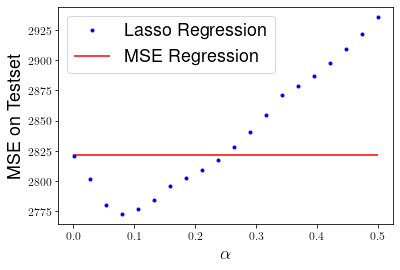

In [35]:
plt.plot(alphas,mses,'b.', label="Lasso Regression")
plt.hlines(mse_linreg, 0, 0.5, "r", label="MSE Regression")
plt.xlabel(r"$\alpha$", fontsize=18)
plt.ylabel("MSE on Testset", fontsize=18)
plt.legend(fontsize=18)
plt.show()

We can see that Lasso performs even better than ridge regression, yielding a lower MSE on the testset for $\alpha \approx 0.09$.

Finally lets investigate how the size of the components $\beta_j$ changes for different values of the hyperparameters.

In [36]:
betas_l = []
mses = []
alphas = np.linspace(0.1,10,20)

for alpha in alphas:
    lasso_reg = Lasso(alpha)
    # Compute estimators
    lasso_reg.fit(X_train, y_train)
    betas_l.append(lasso_reg.coef_)
    # Compute their MSE
    mses.append(mean_squared_error(lasso_reg.predict(X_test), y_test))
    
betas_r = []
mses = []
lbdas = np.linspace(1,1000,20)

for lbda in lbdas:
    # Compute estimators
    beta = np.linalg.inv(X_train.T.dot(X_train)+lbda*np.eye(np.shape(X_train)[1])).dot(X_train.T).dot(y_train)
    betas_r.append(beta)
    # Compute their MSE
    mses.append(mean_squared_error(X_test.dot(beta), y_test))

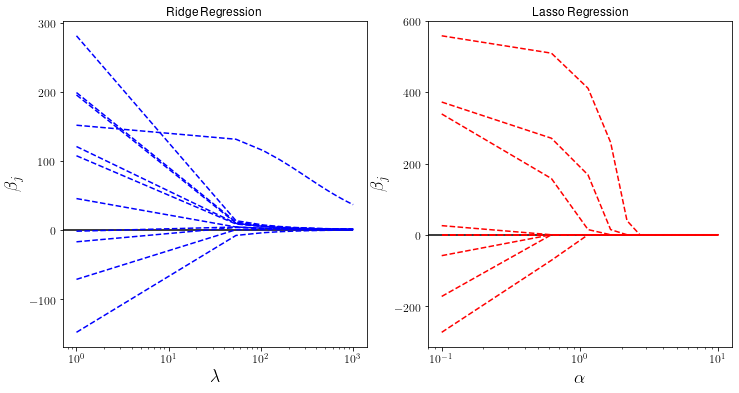

In [37]:
plt.figure(figsize=(12,6))
plt.subplot(121)


plt.plot(lbdas,betas_r,'b--', label="Ridge Regression")
plt.xlabel("$\lambda$", fontsize=18)
plt.hlines(0,0,1000)
plt.xscale("log")
plt.ylabel(r"$\beta_j$", fontsize=18)
plt.title("Ridge Regression")
plt.subplot(122)
plt.plot(alphas,betas_l,'r--', label="Lasso Regression")
plt.title("Lasso Regression")
plt.hlines(0,0,10)
plt.xscale("log")
plt.xlabel(r"$\alpha$", fontsize=18)
plt.ylabel(r"$\beta_j$", fontsize=18)
plt.show()


Notice that as $\alpha$ increases some parameters actually vanish and can be ignored completely. This actually corresponds to dropping certain data features completely and can be useful if we are interested in selecting the most important features in a dataset.